In [1]:
import os
import numpy as np
import pandas as pd
import time
import glob
import pathlib
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from plotnine import *
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error

import sys
sys.path.append("/tf/model/vggish")

import vggish_params 
import vggish_input
import mel_features

seed = 27
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200

BATCH_SIZE=128
DROPOUT=0.2
LEARNING_RATE=0.001
CLASSIFICATION_RATIO=0.995

In [4]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [5]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
size_sec = 30
stride_sec = 0.1

In [8]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    mmse = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    group = tf.gather(meta.Group.map({'cc': 0, 'cd': 1}), tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=int(44100*size_sec), stride=int(44100*stride_sec))
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, mmse, group

In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda x,y,z: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices([y]), 
                                        tf.data.Dataset.from_tensor_slices([z]) 
                                    ))
                                )))\
                        .shuffle(100)
    return output_ds

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [11]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)


(30, 257, 1)
(<tf.Tensor: shape=(), dtype=int64, numpy=30>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [12]:
batch_size = 32
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [13]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

In [14]:
input = layers.Input(shape=input_shape)
reshape = layers.Reshape((input_shape[0],input_shape[1]))(input)
norm = norm_layer(reshape)

dense1 = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(norm)
dropout1 = layers.Dropout(0.25)(dense1)
lstm1 = layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True)(dropout1)
dropout2 = layers.Dropout(0.25)(lstm1)
lstm2 = layers.LSTM(64, activation='relu', kernel_initializer='he_normal')(dropout2)
dropout3 = layers.Dropout(0.25)(lstm2)
dense2 = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout3)
dropout4 = layers.Dropout(0.25)(dense2)

mmse = layers.Dense(1, activation='relu', name='mmse')(dropout4)
classification = layers.Dense(1, activation='sigmoid', name='classification')(dropout4)

model = tf.keras.Model(
    inputs=input,
    outputs=[mmse, classification],
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 257, 1)] 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 30, 257)      0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 30, 257)      3           reshape[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 30, 256)      66048       normalization[0][0]              
______________________________________________________________________________________________

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss = ['mse','binary_crossentropy'],
    loss_weights=[1-CLASSIFICATION_RATIO, CLASSIFICATION_RATIO]
)

In [16]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/1000
3/3 [==============================] - 12s 5s/step - loss: 9.4776 - mmse_loss: 727.7107 - classification_loss: 5.8684 - val_loss: 34.4334 - val_mmse_loss: 1765.2908 - val_classification_loss: 25.7357
Epoch 2/1000
3/3 [==============================] - 0s 95ms/step - loss: 12.8567 - mmse_loss: 972.4613 - classification_loss: 8.0346 - val_loss: 43.1507 - val_mmse_loss: 590.8755 - val_classification_loss: 40.3983
Epoch 3/1000
3/3 [==============================] - 0s 90ms/step - loss: 30.5942 - mmse_loss: 3559.5458 - classification_loss: 12.8608 - val_loss: 43.7473 - val_mmse_loss: 631.9938 - val_classification_loss: 40.7913
Epoch 4/1000
3/3 [==============================] - 0s 102ms/step - loss: 24.8713 - mmse_loss: 1190.5455 - classification_loss: 19.0136 - val_loss: 37.8635 - val_mmse_loss: 616.7257 - val_classification_loss: 34.9546
Epoch 5/1000
3/3 [==============================] - 0s 97ms/step - loss: 23.3012 - mmse_loss: 1606.3295 - classification_loss: 15.3463 - val

3/3 [==============================] - 0s 94ms/step - loss: 3.6210 - mmse_loss: 427.6693 - classification_loss: 1.4901 - val_loss: 1.4895 - val_mmse_loss: 165.0488 - val_classification_loss: 0.6676
Epoch 40/1000
3/3 [==============================] - 0s 99ms/step - loss: 2.0790 - mmse_loss: 170.8558 - classification_loss: 1.2308 - val_loss: 1.1259 - val_mmse_loss: 98.4339 - val_classification_loss: 0.6369
Epoch 41/1000
3/3 [==============================] - 0s 98ms/step - loss: 1.8879 - mmse_loss: 141.3265 - classification_loss: 1.1872 - val_loss: 1.1625 - val_mmse_loss: 111.8913 - val_classification_loss: 0.6061
Epoch 42/1000
3/3 [==============================] - 0s 99ms/step - loss: 2.2994 - mmse_loss: 189.7592 - classification_loss: 1.3574 - val_loss: 1.1784 - val_mmse_loss: 109.7193 - val_classification_loss: 0.6330
Epoch 43/1000
3/3 [==============================] - 0s 92ms/step - loss: 1.9715 - mmse_loss: 135.8468 - classification_loss: 1.2988 - val_loss: 1.1412 - val_mmse_loss

Epoch 78/1000
3/3 [==============================] - 0s 97ms/step - loss: 1.1328 - mmse_loss: 83.2403 - classification_loss: 0.7202 - val_loss: 1.3114 - val_mmse_loss: 96.6271 - val_classification_loss: 0.8324
Epoch 79/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.9417 - mmse_loss: 77.9819 - classification_loss: 0.5546 - val_loss: 0.9292 - val_mmse_loss: 65.8240 - val_classification_loss: 0.6031
Epoch 80/1000
3/3 [==============================] - 0s 97ms/step - loss: 1.2970 - mmse_loss: 90.3946 - classification_loss: 0.8492 - val_loss: 0.9310 - val_mmse_loss: 69.6790 - val_classification_loss: 0.5855
Epoch 81/1000
3/3 [==============================] - 0s 99ms/step - loss: 1.0465 - mmse_loss: 103.7126 - classification_loss: 0.5306 - val_loss: 1.0574 - val_mmse_loss: 85.6101 - val_classification_loss: 0.6325
Epoch 82/1000
3/3 [==============================] - 0s 93ms/step - loss: 1.0777 - mmse_loss: 78.1007 - classification_loss: 0.6907 - val_loss: 1.1147 - val_m

Epoch 117/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.7521 - mmse_loss: 74.8083 - classification_loss: 0.3800 - val_loss: 2.3763 - val_mmse_loss: 76.4702 - val_classification_loss: 2.0039
Epoch 118/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.6322 - mmse_loss: 51.9121 - classification_loss: 0.3746 - val_loss: 1.8947 - val_mmse_loss: 74.7433 - val_classification_loss: 1.5286
Epoch 119/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.6986 - mmse_loss: 69.7852 - classification_loss: 0.3515 - val_loss: 1.9739 - val_mmse_loss: 119.7457 - val_classification_loss: 1.3821
Epoch 120/1000
3/3 [==============================] - 0s 103ms/step - loss: 0.8545 - mmse_loss: 90.2920 - classification_loss: 0.4051 - val_loss: 1.6878 - val_mmse_loss: 89.4138 - val_classification_loss: 1.2470
Epoch 121/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.6413 - mmse_loss: 66.9210 - classification_loss: 0.3083 - val_loss: 1.6367 - 

Epoch 156/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.4076 - mmse_loss: 49.0323 - classification_loss: 0.1632 - val_loss: 2.0204 - val_mmse_loss: 74.3811 - val_classification_loss: 1.6567
Epoch 157/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.4955 - mmse_loss: 70.7574 - classification_loss: 0.1424 - val_loss: 1.9878 - val_mmse_loss: 87.5493 - val_classification_loss: 1.5578
Epoch 158/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.5236 - mmse_loss: 59.5329 - classification_loss: 0.2271 - val_loss: 2.1778 - val_mmse_loss: 85.3590 - val_classification_loss: 1.7598
Epoch 159/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.5216 - mmse_loss: 51.8295 - classification_loss: 0.2637 - val_loss: 2.3544 - val_mmse_loss: 70.2563 - val_classification_loss: 2.0131
Epoch 160/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.6058 - mmse_loss: 57.4153 - classification_loss: 0.3203 - val_loss: 2.1888 - 

Epoch 195/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.3799 - mmse_loss: 55.1112 - classification_loss: 0.1049 - val_loss: 3.3862 - val_mmse_loss: 89.0839 - val_classification_loss: 2.9556
Epoch 196/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.2911 - mmse_loss: 37.6297 - classification_loss: 0.1035 - val_loss: 3.3705 - val_mmse_loss: 81.4897 - val_classification_loss: 2.9779
Epoch 197/1000
3/3 [==============================] - 0s 131ms/step - loss: 0.3451 - mmse_loss: 58.8649 - classification_loss: 0.0510 - val_loss: 3.7543 - val_mmse_loss: 103.2156 - val_classification_loss: 3.2545
Epoch 198/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.3053 - mmse_loss: 50.7652 - classification_loss: 0.0517 - val_loss: 3.5060 - val_mmse_loss: 69.9711 - val_classification_loss: 3.1720
Epoch 199/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.3293 - mmse_loss: 46.0141 - classification_loss: 0.0997 - val_loss: 3.8916 - 

Epoch 234/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.2579 - mmse_loss: 42.1141 - classification_loss: 0.0476 - val_loss: 2.8027 - val_mmse_loss: 97.9189 - val_classification_loss: 2.3247
Epoch 235/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.2498 - mmse_loss: 46.8509 - classification_loss: 0.0156 - val_loss: 3.8310 - val_mmse_loss: 96.1795 - val_classification_loss: 3.3669
Epoch 236/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.2051 - mmse_loss: 37.9722 - classification_loss: 0.0154 - val_loss: 4.2891 - val_mmse_loss: 81.9638 - val_classification_loss: 3.8988
Epoch 237/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.2528 - mmse_loss: 48.9787 - classification_loss: 0.0079 - val_loss: 4.1644 - val_mmse_loss: 79.6351 - val_classification_loss: 3.7852
Epoch 238/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.2733 - mmse_loss: 53.8643 - classification_loss: 0.0040 - val_loss: 3.7842 - 

Epoch 273/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.2109 - mmse_loss: 39.3758 - classification_loss: 0.0141 - val_loss: 4.2451 - val_mmse_loss: 86.8902 - val_classification_loss: 3.8298
Epoch 274/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.2442 - mmse_loss: 46.1035 - classification_loss: 0.0138 - val_loss: 4.4222 - val_mmse_loss: 90.9561 - val_classification_loss: 3.9874
Epoch 275/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.1935 - mmse_loss: 37.2015 - classification_loss: 0.0075 - val_loss: 4.1566 - val_mmse_loss: 103.0254 - val_classification_loss: 3.6598
Epoch 276/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.1527 - mmse_loss: 28.0718 - classification_loss: 0.0124 - val_loss: 3.5046 - val_mmse_loss: 95.5083 - val_classification_loss: 3.0422
Epoch 277/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.1810 - mmse_loss: 34.1535 - classification_loss: 0.0102 - val_loss: 3.3787 - 

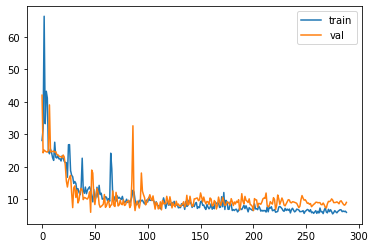

In [17]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mmse_loss']), np.sqrt(metrics['val_mmse_loss']))
plt.legend(['train', 'val'])
plt.show()

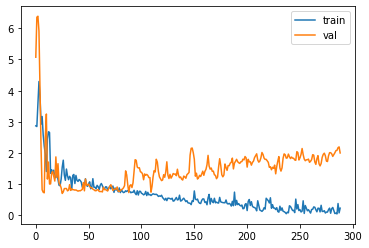

In [18]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['classification_loss']), np.sqrt(metrics['val_classification_loss']))
plt.legend(['train', 'val'])
plt.show()

In [19]:
meta = meta.assign(split = '', predict_mmse = -99.99, predict_group_prob = 0)

def applyModelStats(file, split_type):
    
    id = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    
    meta.loc[meta["ID"]==id,'split'] = split_type
    predict = model.predict(get_data(file)[0])
    
    median_predict = np.percentile(predict[0], 50)   
    predict25 = np.percentile(predict[0], 25)   
    predict75 = np.percentile(predict[0], 75)   
    
    avg_predict_group_prob = np.median(predict[1][:,0])
    std_predict_group_prob = np.std(predict[1][:,0])
    
    meta.loc[meta["ID"]==id,'predict_mmse_median'] = median_predict
    meta.loc[meta["ID"]==id,'predict_mmse_25'] = predict25
    meta.loc[meta["ID"]==id,'predict_mmse_75'] = predict75
    
    meta.loc[meta["ID"]==id,'predict_group_prob'] = avg_predict_group_prob
    meta.loc[meta["ID"]==id,'predict_group_prob_std'] = std_predict_group_prob


for file in train_files:
    applyModelStats(file, "train")
    
for file in val_files:
    applyModelStats(file, "val")
    
for file in test_files:
    applyModelStats(file, "test")

ResourceExhaustedError: OOM when allocating tensor with shape[641,1323000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: packed

In [ ]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict_mmse_median'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

In [ ]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

In [ ]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict_mmse_median'] ))

In [ ]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict_mmse_median', colour = 'split')) + \
geom_errorbar(aes(x='MMSE', ymin='predict_mmse_25', ymax='predict_mmse_75'), width=.2) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

In [ ]:
y = meta.Group.apply(lambda x: 1 if x=="cd" else 0)
probs = meta.predict_group_prob

lr_auc = roc_auc_score(y, probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()

In [ ]:
# model.save('saved_model/base_line/20210222')

In [ ]:
ls saved_model/base_line